In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import numpy as np

from RunningEnv import EnvWrapper
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns


In [12]:
#discount factor for future utilities
DISCOUNT_FACTOR = 0.99

#number of episodes to run
NUM_EPISODES = 1000

#max steps per episode
MAX_STEPS = 10000

#device to run model on 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

FRAMES = 500
pref_pace = 181
target_pace = pref_pace*1.1

In [13]:
#Using a neural network to learn our policy parameters
from torch.autograd import Variable
class PolicyNetwork(nn.Module):
    
    #Takes in observations and outputs actions
    def __init__(self, observation_space, action_space):
        super(PolicyNetwork, self).__init__()
        self.input_layer = nn.Linear(observation_space, 128)
        self.output_layer = nn.Linear(128, action_space)
    
    #forward pass
    def forward(self, x):
        #input states
        x = self.input_layer(x)
        
        #relu activation
        x = F.relu(x)
        
        #actions
        actions = self.output_layer(x)
        
        #get softmax for a probability distribution
        action_probs = F.softmax(actions, dim=1)
        
        return action_probs

class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()

    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        actions = self.fc(out) #Final Output

        # #get softmax for a probability distribution
        action_probs = F.softmax(actions, dim=1)

        return action_probs

In [14]:
def select_action(network, state):
    ''' Selects an action given current state
    Args:
    - network (Torch NN): network to process state
    - state (Array): Array of action space in an environment
    
    Return:
    - (int): action that is selected
    - (float): log probability of selecting that action given state and network
    '''
    
    #convert state to float tensor, add 1 dimension, allocate tensor on device
    state = torch.from_numpy(state).float().unsqueeze(0).to(DEVICE)
    state = torch.reshape(state, (state.shape[0], 1, state.shape[1]))
    
    #use network to predict action probabilities
    action_probs = network(state)
    
    #sample an action using the probability distribution
    m = Categorical(action_probs)
    action = m.sample()

    #return action
    return action.item(), m.log_prob(action)

In [15]:
#Make environment
env = EnvWrapper(pref_pace, target_pace)

#Init network
# network = PolicyNetwork(1, 10).to(DEVICE)

input_size = 1 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 10 #number of output classes

network = LSTM1(num_classes, input_size, hidden_size, num_layers, 1).to(DEVICE)

#Init optimizer
optimizer = optim.Adam(network.parameters(), lr=1e-2)

In [16]:
state = env.step(0)
print(state)

(array([-0.03331203]), array([-16.32425899]), array([0]))


In [22]:
state = env.step(0)[0]
select_action(network, state)

(3, tensor([-2.0622], grad_fn=<SqueezeBackward1>))

In [23]:
# track scores
scores = []

# iterate through episodes
for episode in tqdm(range(NUM_EPISODES)):

    # reset environment, initiable variables
    env.reset()
    state = env.step(0)[0]
    rewards = []
    log_probs = []
    score = 0

    # generate episode
    while env.steps < FRAMES:
        # env.render()

        # select action
        action, lp = select_action(network, state)

        # execute action
        new_state, reward, done = env.step(action)

        # track episode score
        score += reward

        # store reward and log probability
        rewards.append(reward)
        log_probs.append(lp)

        # end episode
        if done:
            break

        # move into new state
        state = new_state

    # append score
    scores.append(score)

    # Calculate Gt (cumulative discounted rewards)
    discounted_rewards = []

    # track cumulative reward
    total_r = 0

    # iterate rewards from Gt to G0
    for r in reversed(rewards):
        # Base case: G(T) = r(T)
        # Recursive: G(t) = r(t) + G(t+1)^DISCOUNT
        total_r = r + (np.sign(total_r) * (np.abs(total_r)) ** DISCOUNT_FACTOR)

        # append to discounted rewards
        discounted_rewards.append(total_r)

    # reverse discounted rewards
    rewards = torch.tensor(discounted_rewards).to(DEVICE)
    rewards = torch.flip(rewards, [0])

    # adjusting policy parameters with gradient ascent
    loss = []
    for r, lp in zip(rewards, log_probs):
        # we add a negative sign since network will perform gradient descent and we are doing gradient ascent with REINFORCE
        loss.append(-r * lp)

    # Backpropagation
    optimizer.zero_grad()
    sum(loss).backward()
    optimizer.step()

  0%|          | 0/1000 [00:00<?, ?it/s]

/tmp/ipykernel_157728/213044160.py:57: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  rewards = torch.tensor(discounted_rewards).to(DEVICE)


#### Plotting training score:

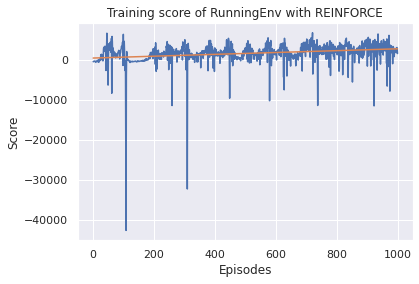

In [24]:
sns.set()

plt.plot(scores)
plt.ylabel('Score')
plt.xlabel('Episodes')
plt.title('Training score of RunningEnv with REINFORCE')

reg = LinearRegression().fit(np.arange(len(scores)).reshape(-1, 1), np.array(scores).reshape(-1, 1))
y_pred = reg.predict(np.arange(len(scores)).reshape(-1, 1))
plt.plot(y_pred)
plt.show()

#### Trying Agent:

In [25]:
done = False
env.reset()
state = env.step(0)[0]
try_scores = []

for _ in tqdm(range(50)):
    env.reset()
    state = env.step(0)[0]
    done = False
    score = 0
    time_step = 0
    while env.steps < FRAMES:
        # env.render()
        action, lp = select_action(network, state)
        new_state, reward, done = env.step(action)
        score += reward
        state = new_state
        if action > 0:
            time_step = time_step + env.times[action%5]
        else:
            time_step = time_step + 1
    try_scores.append(score)

  0%|          | 0/50 [00:00<?, ?it/s]

In [26]:
np.array(try_scores).mean()

2400.272579635518

1 [-0.01748924] [-0.00807433] [-20.]
1 [-0.0057364] [-0.00677185] [-20.]
1 [-0.0085052] [-0.00568879] [-20.]
1 [-0.00334551] [-0.00536079] [-20.]
1 [-0.00562595] [-0.00341578] [-20.]
5 [-0.00258904] [-0.00226792] [20.]
1 [-0.00194548] [-0.00401065] [-20.]
1 [-0.00394784] [-0.00343861] [-20.]
1 [-0.00343861] [-0.00267681] [-20.]
1 [-0.00313512] [-0.00299588] [-20.]
1 [-0.00053994] [-0.002538] [-20.]
1 [-0.00267576] [-0.00436639] [-20.]
1 [-0.00244616] [-0.00217936] [-20.]
1 [-0.00217936] [-0.0023498] [-20.]
1 [-0.00253555] [-7.71308531e-05] [-20.]


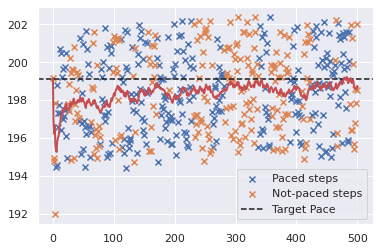

3660.0


In [30]:
env.reset()
state = env.step(0)[0]

while env.steps < FRAMES:
    action, _ = select_action(network, state)
    new_state, reward, done = env.step(action)
    # if reward < 0:
    #     print(action, state, new_state, reward)
    if (action != 0):
    #     # print(action, (state+1)*pref_pace, (new_state+1)*pref_pace, reward)
        print(action, state, new_state, reward)
    state = new_state

x = np.linspace(0, len(env.env_pacing), len(env.env_pacing))
plt.scatter(x[np.array(env.env_pacing)==1], np.array(env.pace)[np.array(env.env_pacing)==1], marker="x", label='Paced steps')
plt.scatter(x[np.array(env.env_pacing)==0], np.array(env.pace)[np.array(env.env_pacing)==0], marker="x", label='Not-paced steps')


# plt.scatter(x[np.array(env_pacing)==1], np.array(pace)[np.array(env_pacing)==1], marker="x", label='Paced steps')
# plt.scatter(x[np.array(env_pacing)==0], np.array(pace)[np.array(env_pacing)==0], marker="x", label='Not-paced steps')

# plt.scatter(x[np.array(pacing)==1], np.array(pacing)[np.array(pacing)==1]*181, color='r', marker="x")
plt.axhline(y=target_pace, color='k', linestyle='--', label='Target Pace')

plt.plot(x, env.state_traj, 'r-', linewidth=2)
plt.legend()
plt.show()

print(np.sum(env.rewards))

### Trying Heuristic agent

In [122]:
class HeuristicAgent:
    def __init__(self):
        self.initial_wait = 20
        self.initial_completed = False

    def select_action(self, state):
        avg_pace = state[0]
        action = 0

        # Initial waiting time
        if not(self.initial_completed):
            self.initial_wait = self.initial_wait - 1
            if self.initial_wait == 0:
                self.initial_completed = True

        if abs(avg_pace) > 27e-3:
            action = 4

        elif abs(avg_pace) > 22e-3:
            action = 3

        elif abs(avg_pace) > 15e-3:
            action = 2

        elif abs(avg_pace) > 11e-3:
            action = 1

        return action

In [123]:
heuristic_agent = HeuristicAgent()
print(heuristic_agent.select_action([0.014]))

1


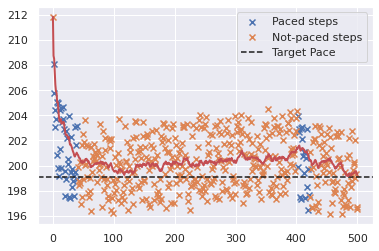

5717.596011363768


In [124]:
heuristic_agent = HeuristicAgent()
env.reset()
state = env.step(0)[0]

while env.steps < FRAMES:
    action = heuristic_agent.select_action(state)
    new_state, reward, _ = env.step(action)
    # if action != 0:
    #     print(action, state, new_state, reward)
    state = new_state

x = np.linspace(0, len(env.env_pacing), len(env.env_pacing))
plt.scatter(x[np.array(env.env_pacing)==1], np.array(env.pace)[np.array(env.env_pacing)==1], marker="x", label='Paced steps')
plt.scatter(x[np.array(env.env_pacing)==0], np.array(env.pace)[np.array(env.env_pacing)==0], marker="x", label='Not-paced steps')


# plt.scatter(x[np.array(env_pacing)==1], np.array(pace)[np.array(env_pacing)==1], marker="x", label='Paced steps')
# plt.scatter(x[np.array(env_pacing)==0], np.array(pace)[np.array(env_pacing)==0], marker="x", label='Not-paced steps')

# plt.scatter(x[np.array(pacing)==1], np.array(pacing)[np.array(pacing)==1]*181, color='r', marker="x")
plt.axhline(y=target_pace, color='k', linestyle='--', label='Target Pace')

plt.plot(x, env.state_traj, 'r-', linewidth=2)
plt.legend()
plt.show()

print(np.sum(env.rewards))

In [125]:
done = False
env.reset()
state = env.step(0)[0]
heuristic_agent = HeuristicAgent()
scores_heuristic = []

for _ in tqdm(range(50)):
    env.reset()
    state = env.step(0)[0]
    done = False
    score = 0

    while env.steps < FRAMES:
        action = heuristic_agent.select_action(state)
        # action = 0
        new_state, _, _ = env.step(action)
        state = new_state
        score += reward
    scores_heuristic.append(score)

  0%|          | 0/50 [00:00<?, ?it/s]

In [126]:
print(np.mean(scores_heuristic))

8581.6


### Play manually

In [127]:
env.reset()
state, reward, _ = env.step(0)
print(state, (state+1)*pref_pace, reward)


[-0.03410645] [174.8267318] [-17.90595017]


In [128]:
action= 2
for i in range(20):
    new_state, reward, done = env.step(action)
    print(action, state, new_state, reward)
    state = new_state

2 [-0.03410645] [-0.00412078] [-25.]
2 [-0.00412078] [-0.00233951] [-25.]
2 [-0.00233951] [-0.00390814] [-25.]
2 [-0.00390814] [-0.00237367] [-25.]
2 [-0.00237367] [-0.00594451] [-25.]
2 [-0.00594451] [-0.00338937] [-25.]
2 [-0.00338937] [-0.00043812] [-25.]
2 [-0.00043812] [0.00037836] [-25.]
2 [0.00037836] [-0.00398511] [-25.]
2 [-0.00398511] [-0.00095211] [-25.]
2 [-0.00095211] [-0.00158242] [-25.]
2 [-0.00158242] [-0.0016637] [-25.]
2 [-0.0016637] [0.00105783] [-25.]
2 [0.00105783] [-4.48724871e-05] [-25.]
2 [-4.48724871e-05] [0.00455073] [-25.]
2 [0.00455073] [0.00056285] [-25.]
2 [0.00056285] [-0.00235077] [-25.]
2 [-0.00235077] [0.00204863] [-25.]
2 [0.00204863] [-0.00199416] [-25.]
2 [-0.00199416] [0.00275893] [-25.]


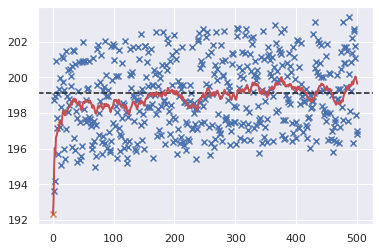

-517.9059501715574


In [129]:
x = np.linspace(0, len(env.env_pacing), len(env.env_pacing))
plt.scatter(x[np.array(env.env_pacing)==1], np.array(env.pace)[np.array(env.env_pacing)==1], marker="x", label='Paced steps')
plt.scatter(x[np.array(env.env_pacing)==0], np.array(env.pace)[np.array(env.env_pacing)==0], marker="x", label='Not-paced steps')


# plt.scatter(x[np.array(env_pacing)==1], np.array(pace)[np.array(env_pacing)==1], marker="x", label='Paced steps')
# plt.scatter(x[np.array(env_pacing)==0], np.array(pace)[np.array(env_pacing)==0], marker="x", label='Not-paced steps')

# plt.scatter(x[np.array(pacing)==1], np.array(pacing)[np.array(pacing)==1]*181, color='r', marker="x")
plt.axhline(y=target_pace, color='k', linestyle='--', label='Target Pace')

plt.plot(x, env.state_traj, 'r-', linewidth=2)
plt.show()

print(np.sum(env.rewards))